In [1]:
import librosa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import librosa.display
import IPython.display
import soundfile as sf
import os
import errno
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.pyplot import specgram
import keras
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix

C:\Users\ioann\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\ioann\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\ioann\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\ioann\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passi

In [2]:
# Need a function to remove dead space from audio files
# Checks a rolling average of signal over 1/10 sec and compares to threshold
# Returns a mask of True and False values that can be used to filter audio signals

def envelope(y, sr, threshold):
    mask = []
    y_abs = pd.Series(y).apply(np.abs)
    y_mean = y_abs.rolling(window = int(sr/10), min_periods = 1, center = True).mean()
    for mean in y_mean:
        if mean > threshold:
            mask.append(True)
        else:
            mask.append(False)
    return np.array(y[mask])

In [3]:
import glob
ravdess_file_list = glob.glob('/Users/ioann/ravdess-speech/*.wav')

In [13]:
def clean_files(file_list):
    count = 0

    for file in file_list:
        y, sr = librosa.load(file)
        y = envelope(y, sr, 0.0005)
        save_file = 'clean/' + file
        
        if not os.path.exists(os.path.dirname(save_file)):
            try:
                os.makedirs(os.path.dirname(save_file))
            except OSError as exc: # Guard against race condition
                if exc.errno != errno.EEXIST:
                    raise
        
        with open(save_file, 'w') as new_file:
            sf.write(save_file, y, sr)
            new_file.close()
            
        count += 1
        if count % 100 == 0:
            print('cleaned and saved 100 files')
    
    print("cleaning complete!")

In [14]:
clean_files(ravdess_file_list)

cleaned and saved 100 files
cleaned and saved 100 files
cleaned and saved 100 files
cleaned and saved 100 files
cleaned and saved 100 files
cleaned and saved 100 files
cleaned and saved 100 files
cleaned and saved 100 files
cleaned and saved 100 files
cleaned and saved 100 files
cleaned and saved 100 files
cleaned and saved 100 files
cleaned and saved 100 files
cleaned and saved 100 files
cleaning complete!


In [15]:
ravdess_file_list

['/Users/ioann/ravdess-speech\\03-01-01-01-01-01-01.wav',
 '/Users/ioann/ravdess-speech\\03-01-01-01-01-01-02.wav',
 '/Users/ioann/ravdess-speech\\03-01-01-01-01-01-03.wav',
 '/Users/ioann/ravdess-speech\\03-01-01-01-01-01-04.wav',
 '/Users/ioann/ravdess-speech\\03-01-01-01-01-01-05.wav',
 '/Users/ioann/ravdess-speech\\03-01-01-01-01-01-06.wav',
 '/Users/ioann/ravdess-speech\\03-01-01-01-01-01-07.wav',
 '/Users/ioann/ravdess-speech\\03-01-01-01-01-01-08.wav',
 '/Users/ioann/ravdess-speech\\03-01-01-01-01-01-09.wav',
 '/Users/ioann/ravdess-speech\\03-01-01-01-01-01-10.wav',
 '/Users/ioann/ravdess-speech\\03-01-01-01-01-01-11.wav',
 '/Users/ioann/ravdess-speech\\03-01-01-01-01-01-12.wav',
 '/Users/ioann/ravdess-speech\\03-01-01-01-01-01-13.wav',
 '/Users/ioann/ravdess-speech\\03-01-01-01-01-01-14.wav',
 '/Users/ioann/ravdess-speech\\03-01-01-01-01-01-15.wav',
 '/Users/ioann/ravdess-speech\\03-01-01-01-01-01-16.wav',
 '/Users/ioann/ravdess-speech\\03-01-01-01-01-01-17.wav',
 '/Users/ioann

In [4]:
ravdess_clean_list = glob.glob('clean/Users/ioann/ravdess-speech/*.wav')

In [5]:
def build_ravdess_index(file_list):
    
    emotion_key = {'01': 'neutral', '02': 'calm', '03': 'happy', '04': 'sad', '05': 'angry', '06': 'fearful', '07': 'disgusted', '08': 'surprised'}
    df = { 'emotion': [] }
   

    for file in file_list:
        props = file.split('-')
        
        df['emotion'].append(emotion_key[props[3]])
        

        
       

       

    file_properties = pd.DataFrame(df)
    
    return file_properties

In [6]:
emotion_list = build_ravdess_index(ravdess_clean_list)

In [7]:
labels = pd.DataFrame(emotion_list)

In [8]:
df = pd.DataFrame(columns=['feature'])
bookmark=0



path = '/Users/ioann/ravdess-speech/'




for subdir, dirs, files in os.walk(path):
    for file in files:
      
        #Load librosa array, obtain mfcss, store the file and the mcss information in a new array
        X, sample_rate = librosa.load(os.path.join(subdir,file), res_type='kaiser_fast')
        mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T,axis=0) 
        feature = mfccs
        df.loc[bookmark] = [feature]
        bookmark=bookmark+1

In [9]:
df4 = pd.DataFrame(df['feature'].values.tolist())
newdf = pd.concat([df4,labels], axis=1)
rnewdf = newdf.rename(index=str, columns={"0": "label"})

In [10]:
from sklearn.utils import shuffle
rnewdf = shuffle(newdf)
rnewdf[:10]

,0,1,2,3,4,5,6,7,8,9,...,31,32,33,34,35,36,37,38,39,emotion
499,-753.344816,48.945060,-16.754839,18.934674,-13.624940,4.281714,-15.806865,-11.221915,-11.211728,0.839155,...,1.569274,2.702786,4.447189,7.052600,6.705773,3.244818,0.888756,0.394028,-0.007686,sad
865,-571.877801,38.611292,-31.418120,9.913748,-17.233219,-4.996909,-13.133022,-11.084112,-10.155733,-3.688057,...,-0.273088,-1.407282,-1.434615,-0.775156,-2.286829,-3.720885,-2.258084,-0.716063,-0.183258,fearful
1249,-581.473760,43.365127,-19.353874,14.792001,-11.855987,-2.937501,-7.267806,-2.006992,-6.774004,-0.227245,...,3.765497,0.718129,2.077591,2.441630,3.761352,1.060193,1.893529,1.674496,1.101543,surprised
495,-675.536781,48.541577,-3.693695,15.501362,-7.372083,-1.366871,-14.761905,-5.579250,-5.142587,-1.491627,...,1.706292,0.030133,1.093912,0.216716,1.608424,-1.338693,0.192503,-0.731679,1.501951,sad
852,-324.772644,15.265379,-22.186864,-3.278732,-22.915528,0.122795,-17.346195,-2.129210,-12.948341,-2.361090,...,-1.905910,-1.647598,3.747710,3.916866,3.550853,3.594135,3.834519,0.045482,-1.354268,angry
794,-331.202340,46.283445,-18.956869,15.017884,-10.334424,1.696586,-12.341080,-10.249897,-10.452085,-1.284022,...,5.995310,2.029377,1.047295,1.717724,2.754452,2.831675,2.482920,0.299475,-0.173076,angry
441,-354.055320,27.405859,-29.257717,3.533830,-10.946123,-11.385460,-15.695774,-12.394151,-20.184299,1.156466,...,-3.257828,-2.317849,-0.566329,-0.224342,-1.872134,-1.263906,-0.346086,-2.405578,-1.114180,happy
374,-602.075433,72.408206,-10.536016,17.867862,10.924235,1.257552,-5.065362,3.291718,-8.234724,0.735900,...,0.712608,-0.033149,-0.441814,-0.677701,0.663381,0.553666,0.230720,0.991062,-0.712371,happy
712,-597.520374,69.926815,-0.082039,20.131766,7.278811,9.026422,3.961001,1.556278,-2.695338,10.118006,...,-1.254193,-0.218056,0.627408,-0.688979,-0.739868,0.734383,-1.439183,-0.987183,-1.783704,angry
1311,-585.277506,44.153442,-10.227004,7.509028,-10.072450,-6.666839,-16.033177,-8.527562,-7.972348,-0.975561,...,0.076418,-2.052019,0.192315,-0.613619,1.674282,-0.516573,-1.904252,-1.754746,0.266391,surprised


In [11]:
newdf1 = np.random.rand(len(rnewdf)) < 0.8
train = rnewdf[newdf1]
test = rnewdf[~newdf1]

In [12]:
rnewdf=rnewdf.fillna(0)

In [13]:
trainfeatures = train.iloc[:, :-1]
trainfeatures

,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
499,-753.344816,48.945060,-16.754839,18.934674,-13.624940,4.281714,-15.806865,-11.221915,-11.211728,0.839155,...,-1.270000,1.569274,2.702786,4.447189,7.052600,6.705773,3.244818,0.888756,0.394028,-0.007686
865,-571.877801,38.611292,-31.418120,9.913748,-17.233219,-4.996909,-13.133022,-11.084112,-10.155733,-3.688057,...,-3.009886,-0.273088,-1.407282,-1.434615,-0.775156,-2.286829,-3.720885,-2.258084,-0.716063,-0.183258
1249,-581.473760,43.365127,-19.353874,14.792001,-11.855987,-2.937501,-7.267806,-2.006992,-6.774004,-0.227245,...,3.930781,3.765497,0.718129,2.077591,2.441630,3.761352,1.060193,1.893529,1.674496,1.101543
495,-675.536781,48.541577,-3.693695,15.501362,-7.372083,-1.366871,-14.761905,-5.579250,-5.142587,-1.491627,...,-0.563119,1.706292,0.030133,1.093912,0.216716,1.608424,-1.338693,0.192503,-0.731679,1.501951
852,-324.772644,15.265379,-22.186864,-3.278732,-22.915528,0.122795,-17.346195,-2.129210,-12.948341,-2.361090,...,-1.972574,-1.905910,-1.647598,3.747710,3.916866,3.550853,3.594135,3.834519,0.045482,-1.354268
794,-331.202340,46.283445,-18.956869,15.017884,-10.334424,1.696586,-12.341080,-10.249897,-10.452085,-1.284022,...,4.989910,5.995310,2.029377,1.047295,1.717724,2.754452,2.831675,2.482920,0.299475,-0.173076
441,-354.055320,27.405859,-29.257717,3.533830,-10.946123,-11.385460,-15.695774,-12.394151,-20.184299,1.156466,...,1.125070,-3.257828,-2.317849,-0.566329,-0.224342,-1.872134,-1.263906,-0.346086,-2.405578,-1.114180
374,-602.075433,72.408206,-10.536016,17.867862,10.924235,1.257552,-5.065362,3.291718,-8.234724,0.735900,...,0.981318,0.712608,-0.033149,-0.441814,-0.677701,0.663381,0.553666,0.230720,0.991062,-0.712371
712,-597.520374,69.926815,-0.082039,20.131766,7.278811,9.026422,3.961001,1.556278,-2.695338,10.118006,...,0.415813,-1.254193,-0.218056,0.627408,-0.688979,-0.739868,0.734383,-1.439183,-0.987183,-1.783704
1311,-585.277506,44.153442,-10.227004,7.509028,-10.072450,-6.666839,-16.033177,-8.527562,-7.972348,-0.975561,...,0.036365,0.076418,-2.052019,0.192315,-0.613619,1.674282,-0.516573,-1.904252,-1.754746,0.266391


In [14]:
trainlabel = train.iloc[:, -1:]

In [15]:
testfeatures = test.iloc[:, :-1]
testlabel = test.iloc[:, -1:]

In [16]:
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder

X_train = np.array(trainfeatures)
y_train = np.array(trainlabel)
X_test = np.array(testfeatures)
y_test = np.array(testlabel)

lb = LabelEncoder()

y_train = np_utils.to_categorical(lb.fit_transform(y_train))
y_test = np_utils.to_categorical(lb.fit_transform(y_test))

C:\Users\ioann\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [17]:
#for cnn
x_traincnn =np.expand_dims(X_train, axis=2)
x_testcnn= np.expand_dims(X_test, axis=2)

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint
model = Sequential()



model.add(Conv1D(256, 5,padding='same',
                 input_shape=(40,1)))
model.add(Activation('relu'))
model.add(Conv1D(128, 5,padding='same'))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
#model.add(Conv1D(128, 5,padding='same',))
#model.add(Activation('relu'))
#model.add(Conv1D(128, 5,padding='same',))
#model.add(Activation('relu'))
#model.add(Dropout(0.2))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dense(8))
model.add(Activation('softmax'))
opt = keras.optimizers.rmsprop(lr=0.00001, decay=1e-6)

In [19]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 40, 256)           1536      
_________________________________________________________________
activation_1 (Activation)    (None, 40, 256)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 40, 128)           163968    
_________________________________________________________________
activation_2 (Activation)    (None, 40, 128)           0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 40, 128)           0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 5, 128)            0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 5, 128)           

In [20]:
model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])

In [ ]:
cnnhistory=model.fit(x_traincnn, y_train, batch_size=16, epochs=700, validation_data=(x_testcnn, y_test))


Train on 1173 samples, validate on 267 samples
Epoch 1/700


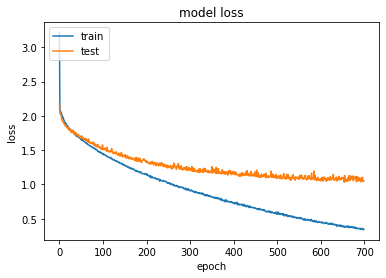

In [45]:
plt.plot(cnnhistory.history['loss'])
plt.plot(cnnhistory.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

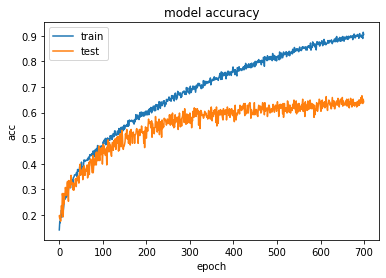

In [46]:
plt.plot(cnnhistory.history['accuracy'])
plt.plot(cnnhistory.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()